In [1]:
%matplotlib inline
import os
import re

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/lfs2/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/lfs2/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (include \s+ '.*\.pro')
    '''


def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [3]:
analysis = scripts.Analysis()

In [4]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = os.path.join('/lfs2/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band04_wn_800_980',
                          'ng_5',
                          'g_ascending_k_descending',
                          'refPTs_P_600_T_250',
                          'ng_refs_5',
                          'getabsth_auto',
                          'absth_dlogN_uniform',
                          'wgt_all1',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'klin_1e-24',
                          'crd_a3d1611',
                          'atmpro_mls')
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [5]:
crdx_wgt = analysis.model('wgt')
crdx_wgt.type_model = 'crd'
crdx_wgt.rundir = os.path.join('/lfs2/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band04_wn_800_980',
                          'ng_5',
                          'g_ascending_k_descending',
                          'refPTs_P_600_T_250',
                          'ng_refs_5',
                          'getabsth_auto',
                          'absth_dlogN_uniform',
                          'wgt_all1',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'klin_1e-24',
                          'crd_a3d1611',
                          'atmpro_mls')
crdx_wgt.fpath_flux = 'output_xfluxg.dat'
crdx_wgt.fpath_coolr = 'output_xcoolrg.dat'
crdx_wgt.linestyle = '--'
crdx_wgt.load_data()

In [6]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [7]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [8]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [9]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [10]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 800

nband = 180

nv = 200

dv = 0.005

tsfc = 294.0

ng = 5

nref = 1

p_refs = (/ 600 /)

t_refs = (/ 250 /)

ng_refs = (/ 5 /)

data wgt
     &     /5*1/

option_wgt_flux = 2

option_wgt_k = 1

option_klin = 1

klin = 1e-24

include 'mls75.pro'


In [11]:
fig.display_hrefanchor()

In [12]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [13]:
table_dgdgs.display_hrefanchor()

In [14]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [15]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [16]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

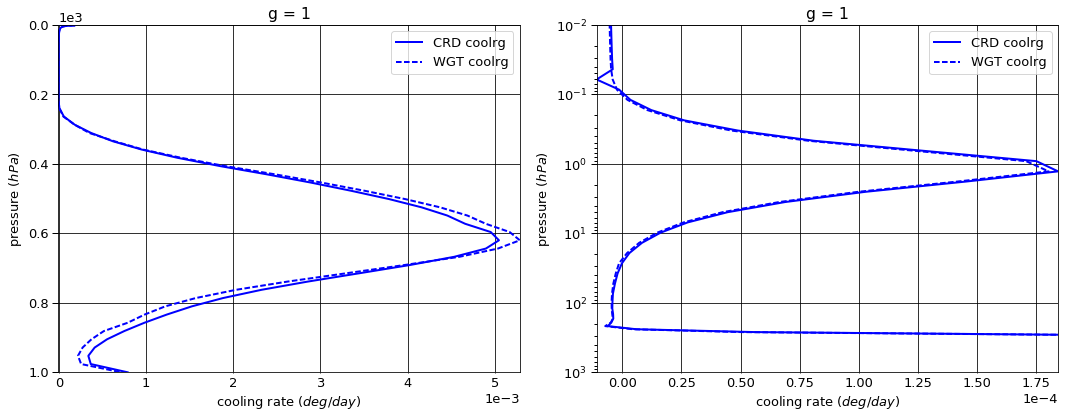

# Figure: cooling rate g-group 2

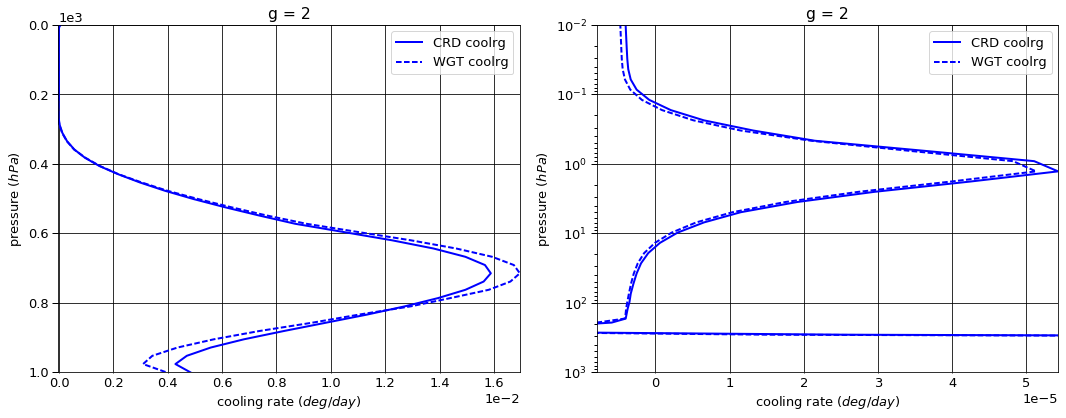

# Figure: cooling rate g-group 3

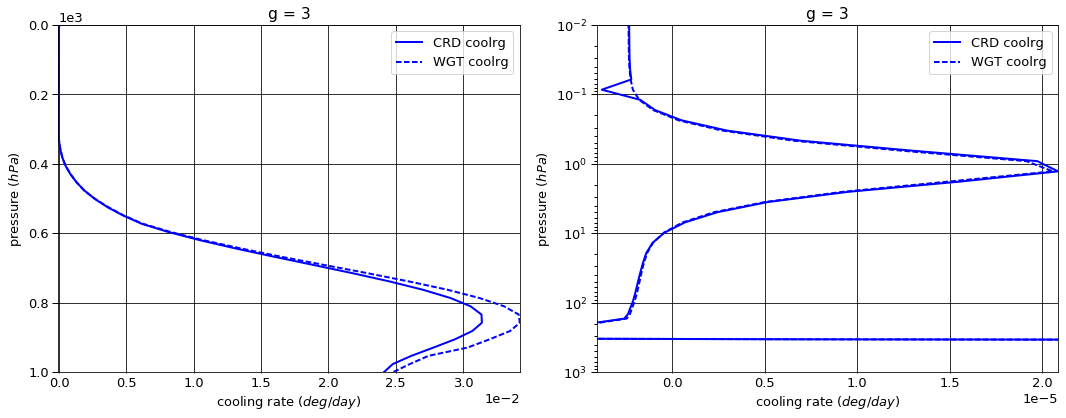

# Figure: cooling rate g-group 4

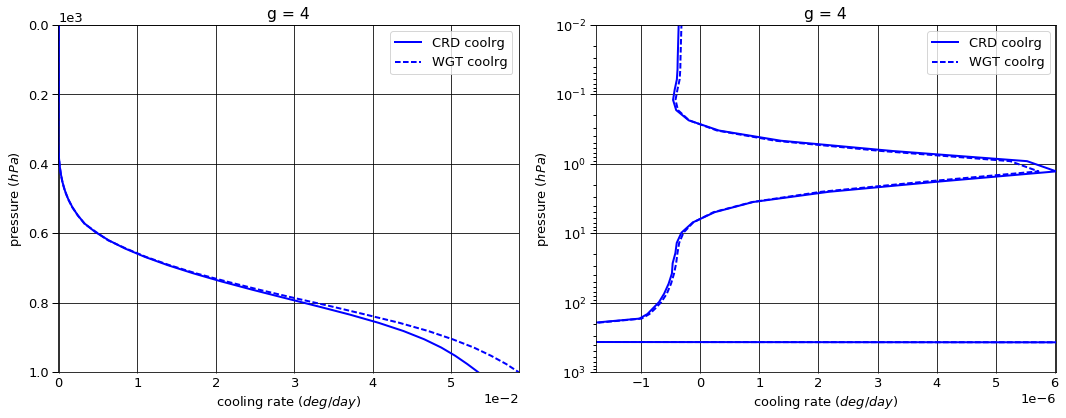

# Figure: cooling rate g-group 5

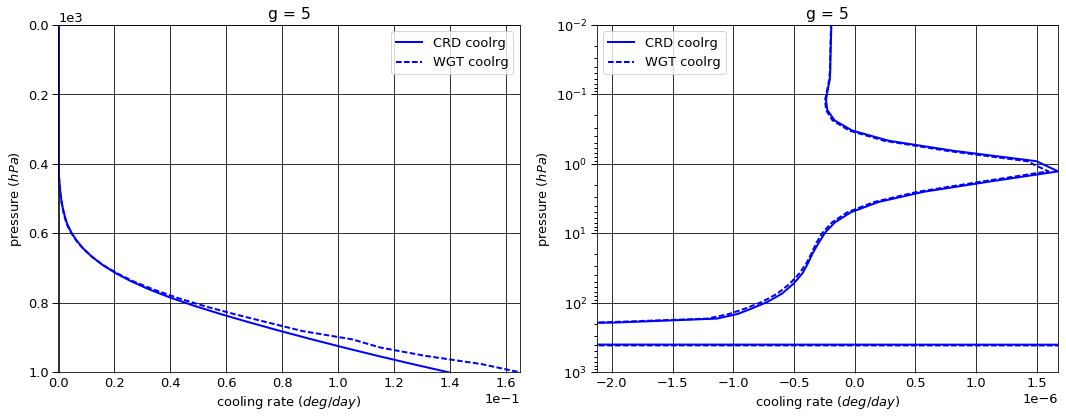

# Figure: cooling rate g-group total

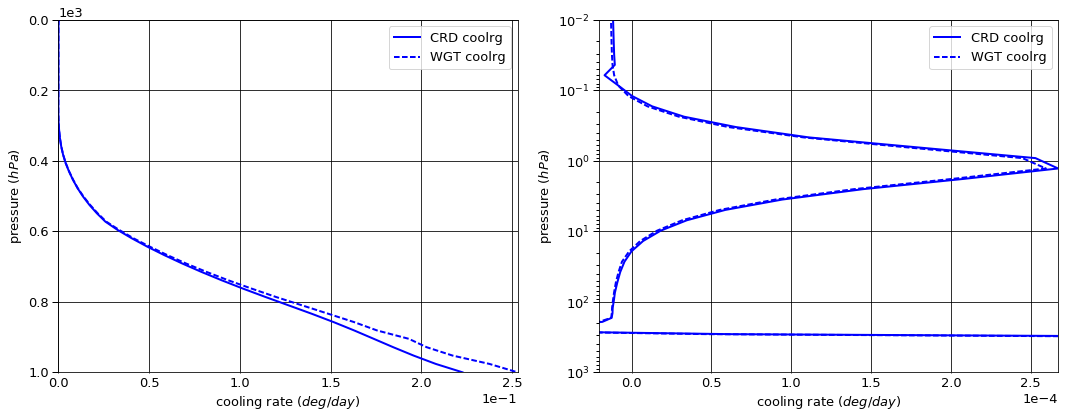

In [17]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [18]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.205606  0.000000  -0.205606
  1013.0   76     -0.325728  0.322797  -0.002932
2 0.0      1      -0.693173  0.000000  -0.693173
  1013.0   76     -0.933073  0.902898  -0.030174
3 0.0      1      -1.595665  0.000000  -1.595665
  1013.0   76     -1.867337  1.531228  -0.336109
4 0.0      1      -3.213811  0.000000  -3.213811
  1013.0   76     -3.446008  1.786736  -1.659272
5 0.0      1     -54.783409  0.000000 -54.783409
  1013.0   76    -55.109100  3.153570 -51.955530


WGT


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.203116  0.000000  -0.203116
  1013.0   76     -0.325728  0.323418  -0.002310
2 0.0      1      -0.684694  0.000000  -0.684694
  1013.0   76     -0.933073  0.915838  -0.017234
3 0.0      1      -1.583105  0.000000  -1.583105
  1013.0   76     -1.867337  1.622912  -0.244425
4 0.0      1      -3.204686  0.000000  -3.204686
  1013.0   76     -3.446008  1.895600  -1.550408
5 0.0      1     -54.757167  0.000000 -54.757167
  1013.0   76    -55.109100  3.520973 -51.588127


WGT - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.002490  0.000000  0.002490
  1013.0   76     0.000000  0.000621  0.000621
2 0.0      1      0.008479  0.000000  0.008479
  1013.0   76     0.000000  0.012940  0.012940
3 0.0      1      0.012560  0.000000  0.012560
  1013.0   76     0.000000  0.091685  0.091685
4 0.0      1      0.009124  0.000000  0.009124
  1013.0   76     0.000000  0.108864  0.108864
5 0.0      1      0.026242  0.000000  0.026242
  1013.0   76     0.000000  0.367403  0.367403

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -5.415024e-06
  1001.112500 75     7.880556e-04
2 0.000312    1     -4.397810e-06
  1001.112500 75     4.832644e-03
3 0.000312    1     -2.337576e-06
  1001.112500 75     2.410556e-02
4 0.000312    1     -3.259613e-07
  1001.112500 75     5.345904e-02
5 0.000312    1     -1.746466e-07
  1001.112500 75     1.395848e-01


WGT


coolrg
g pressure    layer              
1 0.000312    1     -5.878013e-06
  1001.112500 75     7.147925e-04
2 0.000312    1     -5.056082e-06
  1001.112500 75     3.949485e-03
3 0.000312    1     -2.369487e-06
  1001.112500 75     2.476979e-02
4 0.000312    1     -2.808527e-07
  1001.112500 75     5.861988e-02
5 0.000312    1     -1.770482e-07
  1001.112500 75     1.650413e-01


WGT - CRD


coolrg
g pressure    layer              
1 0.000312    1     -4.629890e-07
  1001.112500 75    -7.326314e-05
2 0.000312    1     -6.582719e-07
  1001.112500 75    -8.831590e-04
3 0.000312    1     -3.191160e-08
  1001.112500 75     6.642290e-04
4 0.000312    1      4.510862e-08
  1001.112500 75     5.160844e-03
5 0.000312    1     -2.401630e-09
  1001.112500 75     2.545642e-02

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.491664,0.000000,-60.491664
1013.0,76,-61.681246,7.697229,-53.984017



WGT


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.432768,0.000000,-60.432768
1013.0,76,-61.681246,8.278742,-53.402504



WGT - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.058895,0.000000,0.058895
1013.0,76,0.000000,0.581513,0.581513


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000013
1001.112500,75,0.222770



WGT


,,coolrg
pressure,layer,
0.000312,1,-0.000014
1001.112500,75,0.253095



WGT - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000001
1001.112500,75,0.030325


In [19]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.004972,0.005447
2,0.014417,0.015506
3,0.029500,0.030696
4,0.054889,0.056411
5,0.896222,0.891940


In [20]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,4.112775e-23
2,1.191856e-23
3,3.453922e-24
4,1.000925e-24
5,2.367330e-27


In [21]:
def spreadsheet():
    ng = crd.data['dgdgs'].dims['g']
    ng_refs = [5]
    p_refs = [600]
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [22]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet())

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,4.112775e-23,NaN,0.004972,0.005447,0.004972,0.005447,600.0
2,1.191856e-23,0.289794,0.014417,0.015506,0.019389,0.020953,600.0
3,3.453922e-24,0.289794,0.029500,0.030696,0.048889,0.051649,600.0
4,1.000925e-24,0.289794,0.054889,0.056411,0.103778,0.108060,600.0
5,2.367330e-27,0.002365,0.896222,0.891940,1.000000,1.000000,600.0


In [23]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [24]:
pd.set_option('display.max_rows', None)
display.display(
    pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1],
                sep=r'\s+')
    )
pd.reset_option('display.max_rows')

pressure       absmean    absmeanlog      ratio
layer g                                                    
1     1     0.000312  3.841752e-23  3.549681e-24  10.822811
      2     0.000312  7.481745e-24  3.044547e-25  24.574243
      3     0.000312  1.256975e-24  6.319087e-26  19.891721
      4     0.000312  6.660778e-26  9.658139e-27   6.896544
      5     0.000312  2.203556e-27  2.449314e-29  89.966263
2     1     0.000750  3.877894e-23  3.557158e-24  10.901665
      2     0.000750  7.519610e-24  3.054598e-25  24.617349
      3     0.000750  1.263930e-24  6.334490e-26  19.953143
      4     0.000750  6.742223e-26  9.700859e-27   6.950130
      5     0.000750  2.224694e-27  2.463775e-29  90.296132
3     1     0.001052  3.955563e-23  3.572450e-24  11.072410
      2     0.001052  7.600905e-24  3.075096e-25  24.717620
      3     0.001052  1.278922e-24  6.365796e-26  20.090534
      4     0.001052  6.918659e-26  9.789727e-27   7.067265
      5     0.001052  2.270231e-27  2.488486e-29  91.229405
4     1     0.001476  4.039255e-23  3.588819e-24  11.255107
      2     0.001476  7.688059e-24  3.096770e-25  24.826057
      3     0.001476  1.295080e-24  6.398535e-26  20.240260
      4     0.001476  7.110760e-26  9.883172e-27   7.194815
      5     0.001476  2.319524e-27  2.515995e-29  92.191127
5     1     0.002070  4.124559e-23  3.605452e-24  11.439782
      2     0.002070  7.776419e-24  3.118529e-25  24.936178
      3     0.002070  1.311550e-24  6.431040e-26  20.394062
      4     0.002070  7.308666e-26  9.976184e-27   7.326114
      5     0.002070  2.370013e-27  2.545614e-29  93.101803
6     1     0.002904  4.211422e-23  3.622409e-24  11.626026
      2     0.002904  7.865908e-24  3.140458e-25  25.047013
      3     0.002904  1.328322e-24  6.463454e-26  20.551268
      4     0.002904  7.512360e-26  1.006886e-26   7.460982
      5     0.002904  2.421684e-27  2.578152e-29  93.931000
7     1     0.004074  4.299872e-23  3.639804e-24  11.813472
      2     0.004074  7.956520e-24  3.162704e-25  25.157336
      3     0.004074  1.345396e-24  6.496017e-26  20.711091
      4     0.004074  7.721999e-26  1.016147e-26   7.599290
      5     0.004074  2.474575e-27  2.614799e-29  94.637291
8     1     0.005714  4.389934e-23  3.657798e-24  12.001577
      2     0.005714  8.048241e-24  3.185475e-25  25.265432
      3     0.005714  1.362773e-24  6.529065e-26  20.872399
      4     0.005714  7.937742e-26  1.025441e-26   7.740810
      5     0.005714  2.528726e-27  2.657242e-29  95.163564
9     1     0.008015  4.481654e-23  3.676624e-24  12.189591
      2     0.008015  8.141056e-24  3.209066e-25  25.368930
      3     0.008015  1.380451e-24  6.563076e-26  21.033597
      4     0.008015  8.159783e-26  1.034823e-26   7.885195
      5     0.008015  2.584194e-27  2.707875e-29  95.432559
10    1     0.011243  4.575046e-23  3.696606e-24  12.376343
      2     0.011243  8.234899e-24  3.233879e-25  25.464457
      3     0.011243  1.398420e-24  6.598710e-26  21.192319
      4     0.011243  8.388230e-26  1.044372e-26   8.031841
      5     0.011243  2.641024e-27  2.770071e-29  95.341403
11    1     0.015771  4.670124e-23  3.718203e-24  12.560164
      2     0.015771  8.329671e-24  3.260488e-25  25.547310
      3     0.015771  1.416660e-24  6.636900e-26  21.345210
      4     0.015771  8.623173e-26  1.054197e-26   8.179846
      5     0.015771  2.699271e-27  2.848583e-29  94.758378
12    1     0.022122  4.766960e-23  3.742077e-24  12.738807
      2     0.022122  8.425288e-24  3.289710e-25  25.611035
      3     0.022122  1.435156e-24  6.678983e-26  21.487638
      4     0.022122  8.864813e-26  1.064462e-26   8.327978
      5     0.022122  2.759036e-27  2.950098e-29  93.523550
13    1     0.031031  4.865648e-23  3.769161e-24  12.909100
      2     0.031031  8.521628e-24  3.322697e-25  25.646719
      3     0.031031  1.453879e-24  6.726841e-26  21.613105
      4     0.031031  9.113374e-26  1.075395e-26   8.474442
      5     0.031031  2.820457e-27  3.083954e-29  91

# Histogram of wavenumbers in g-group 1

In [25]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [26]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
